Training neural network with custom Bayes (BOLT) loss...
Epoch 10/200, Loss: 0.1753
Epoch 20/200, Loss: 0.1567
Epoch 30/200, Loss: 0.1526
Epoch 40/200, Loss: 0.1515
Epoch 50/200, Loss: 0.1505
Epoch 60/200, Loss: 0.1501
Epoch 70/200, Loss: 0.1501
Epoch 80/200, Loss: 0.1492
Epoch 90/200, Loss: 0.1491
Epoch 100/200, Loss: 0.1489
Epoch 110/200, Loss: 0.1499
Epoch 120/200, Loss: 0.1484
Epoch 130/200, Loss: 0.1479
Epoch 140/200, Loss: 0.1479
Epoch 150/200, Loss: 0.1471
Epoch 160/200, Loss: 0.1472
Epoch 170/200, Loss: 0.1464
Epoch 180/200, Loss: 0.1465
Epoch 190/200, Loss: 0.1455
Epoch 200/200, Loss: 0.1450
Average Test Loss (BOLT Loss): 0.1520
Neural Network Test Accuracy: 0.8479
Neural Network Test Error Rate: 0.1521
Base Classifier-Independent Bound (Bayes Error Estimate): 0.15243269951019317
Ensemble Classifier-Independent Bound (Bayes Error Estimate): 0.15286232136973682


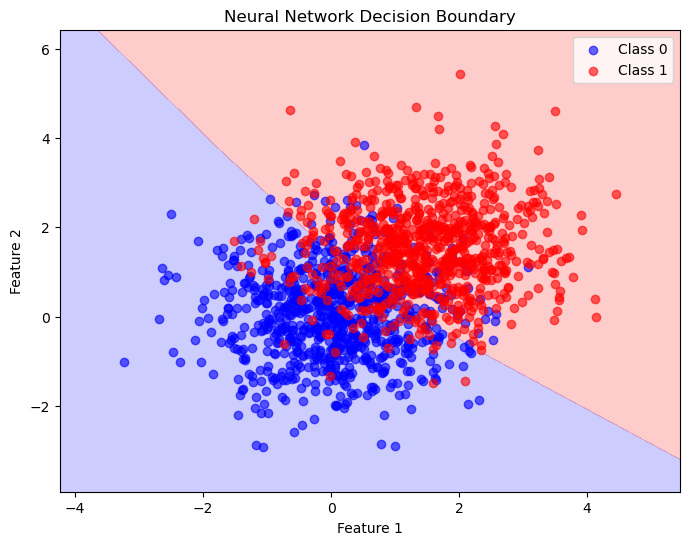

In [3]:
import numpy as np
from sklearn.neighbors import BallTree
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# --------------------------
# Part 1: Epsilon-ball Density Ratio Estimation Functions
# --------------------------
def compute_density_ratio_estimates(X, Y, epsilon):
    """
    For each point in Y, count neighbors in X and Y within radius epsilon.
    Then compute the density ratio estimate:
      Uhat = eta * (count in X) / (count in Y),
    where eta = len(Y)/len(X).
    """
    tree_X = BallTree(X)
    tree_Y = BallTree(Y)
    eta = len(Y) / len(X)
    Uhat = np.zeros(len(Y))
    
    ind_X = tree_X.query_radius(Y, r=epsilon)
    ind_Y = tree_Y.query_radius(Y, r=epsilon)
    
    for i in range(len(Y)):
        count_X = len(ind_X[i])
        count_Y = len(ind_Y[i])
        Uhat[i] = eta * count_X / count_Y if count_Y > 0 else 0
    return Uhat

def compute_bayes_error_estimate(X, Y, epsilon, t_const=0.0):
    """
    Computes the base estimator of the Bayes error as:
      E_est = min(p1, p2) - (1/|Y|)*sum_i t̃(Uhat_i)
    where t(u) = max(p2 - p1*u, 0) - max(p2 - p1, 0) and t̃(u) = max(t(u), t_const).
    """
    N1, N2 = len(X), len(Y)
    p1 = N1 / (N1 + N2)
    p2 = N2 / (N1 + N2)
    
    Uhat = compute_density_ratio_estimates(X, Y, epsilon)
    t_offset = np.maximum(p2 - p1, 0)
    t_vals = np.maximum(p2 - p1 * Uhat, 0) - t_offset
    t_tilde = np.maximum(t_vals, t_const)
    E_est = min(p1, p2) - np.mean(t_tilde)
    return E_est

def compute_ensemble_density_ratio_estimates(X, Y, epsilons, weights):
    """
    Computes a weighted ensemble of density ratio estimates over multiple ε values.
    """
    all_Uhat = []
    for eps in epsilons:
        Uhat = compute_density_ratio_estimates(X, Y, eps)
        all_Uhat.append(Uhat)
    all_Uhat = np.vstack(all_Uhat)  # shape: (L, len(Y))
    Uhat_w = np.average(all_Uhat, axis=0, weights=weights)
    return Uhat_w

def compute_ensemble_bayes_error_estimate(X, Y, epsilons, weights, t_const=0.0):
    """
    Computes the ensemble Bayes error estimate using the weighted density ratio:
      E_est = min(p1, p2) - (1/|Y|)*sum_i t̃(Uhat_w[i])
    """
    N1, N2 = len(X), len(Y)
    p1 = N1 / (N1 + N2)
    p2 = N2 / (N1 + N2)
    
    Uhat_w = compute_ensemble_density_ratio_estimates(X, Y, epsilons, weights)
    t_offset = np.maximum(p2 - p1, 0)
    t_vals = np.maximum(p2 - p1 * Uhat_w, 0) - t_offset
    t_tilde = np.maximum(t_vals, t_const)
    E_est = min(p1, p2) - np.mean(t_tilde)
    return E_est

# --------------------------
# Part 2: Neural Network Classifier and Custom Bayes (BOLT) Loss in PyTorch
# --------------------------
# Custom Bayes loss function (BOLT loss) for binary classification.
# Expects:
#   output: logits of shape (batch_size, 2)
#   target: LongTensor of shape (batch_size) with class labels 0 or 1.
def Bayes_loss_binary(output, target, norm='l1'):
    output = F.softmax(output, dim=1)
    output = output[:, 1:2]
    batch_size = output.size(0)
    num_classes = output.size(1)
    mask = torch.arange(num_classes, device=target.device).expand(batch_size, num_classes)
    target = target.unsqueeze(1).expand_as(mask)
    loss = (mask >= target).float() * output
    loss += (mask == (target - 1)).float() * (1 - output)
    if norm == 'l2':
        loss = (loss ** 2).sum() / batch_size
    elif norm == 'l1':
        loss = loss.abs().sum() / batch_size
    else:
        raise ValueError("Norm must be 'l1' or 'l2'")
    return loss

# Simple neural network model for binary classification.
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        # Output layer: 2 logits for binary classification
        self.out = nn.Linear(8, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.out(x)
        return logits

def train_nn_model(model, optimizer, loss_fn, train_loader, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        # Print average loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")
    return model

def evaluate_nn_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            # Get predicted class (0 or 1) from logits
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    accuracy = correct / total
    return accuracy

def evaluate_custom_loss(model, test_loader, loss_fn):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss = loss_fn(output, target)
            total_loss += loss.item() * data.size(0)
            total_samples += data.size(0)
    avg_loss = total_loss / total_samples
    return avg_loss

# --------------------------
# Part 3: Main Execution - Data Generation, Training, and Comparison
# --------------------------
if __name__ == '__main__':
    # Generate synthetic data for two classes.
    np.random.seed(42)
    N1, N2 = 800, 800
    dim = 2
    # Class 0: centered at (0,0)
    X_class0 = np.random.randn(N1, dim)
    # Class 1: centered at (1.5, 1.5)
    X_class1 = np.random.randn(N2, dim) + 1.5

    # Combine data and labels for neural network training.
    X_all = np.vstack([X_class0, X_class1])
    y_all = np.hstack([np.zeros(N1, dtype=np.int64), np.ones(N2, dtype=np.int64)])

    # Split into training and test sets.
    X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_all, y_all, test_size=0.3, random_state=42)
    
    # Convert numpy arrays to PyTorch tensors.
    X_train = torch.tensor(X_train_np, dtype=torch.float32)
    y_train = torch.tensor(y_train_np, dtype=torch.long)
    X_test = torch.tensor(X_test_np, dtype=torch.float32)
    y_test = torch.tensor(y_test_np, dtype=torch.long)
    
    # Create PyTorch data loaders.
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Instantiate the neural network model.
    model = SimpleNN(input_dim=dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    
    # Train the neural network using the custom BOLT loss.
    print("Training neural network with custom Bayes (BOLT) loss...")
    model = train_nn_model(model, optimizer, Bayes_loss_binary, train_loader, num_epochs=200)
    
    # Evaluate the neural network on the test set.
    accuracy = evaluate_nn_model(model, test_loader)
    nn_error_rate = 1 - accuracy
    test_loss = evaluate_custom_loss(model, test_loader, Bayes_loss_binary)
    print(f"Average Test Loss (BOLT Loss): {test_loss:.4f}")
    print(f"Neural Network Test Accuracy: {accuracy:.4f}")
    print(f"Neural Network Test Error Rate: {nn_error_rate:.4f}")
    
    # Compute the classifier-independent (Bayes error) bound using the ε–ball method.
    epsilon = 0.5
    base_error_bound = compute_bayes_error_estimate(X_class0, X_class1, epsilon, t_const=0.0)
    print("Base Classifier-Independent Bound (Bayes Error Estimate):", base_error_bound)
    
    # Compute the ensemble bound using multiple ε values.
    epsilons = [0.4, 0.5,0.6]
    weights = [0.33, 0.34, 0.33]  # Example weights (must sum to 1)
    ensemble_error_bound = compute_ensemble_bayes_error_estimate(X_class0, X_class1, epsilons, weights, t_const=0.0)
    print("Ensemble Classifier-Independent Bound (Bayes Error Estimate):", ensemble_error_bound)
    
    # Optional: Plot the neural network decision boundary.
    x_min, x_max = X_all[:, 0].min() - 1, X_all[:, 0].max() + 1
    y_min, y_max = X_all[:, 1].min() - 1, X_all[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)
    
    model.eval()
    with torch.no_grad():
        outputs = model(grid_tensor)
        # Predicted probabilities for class 1.
        probs = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
    probs = probs.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, colors=['blue', 'red'])
    plt.scatter(X_class0[:, 0], X_class0[:, 1], c='blue', label='Class 0', alpha=0.6)
    plt.scatter(X_class1[:, 0], X_class1[:, 1], c='red', label='Class 1', alpha=0.6)
    plt.title("Neural Network Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.savefig("neural_net_decision_boundary.png", dpi=300, bbox_inches="tight")
    plt.show()
